# Clustering CIML

Clustering experiment on CIML.

**Motivation:** During CIML supervised learning on multiple classification experiments, where the classes are cloud operators providing the VMs to run CI jobs, the classes predicted with the best metrics were those with the higher amount of samples in the dataset. 
We want to evaluate if unsupervised learning can group those cloud providers with high support in separate clusters. 

Clustering algorithm: k-means.
<br>Method for deciding the number of clusters: elbow method and silhouette score.


In [91]:
from ciml import gather_results
from ciml import tf_trainer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as pltcolors
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

## Data loading and analysis

From the supervised learning experiments on multiple data classification on CIML data, the best results were obtained for the following experiment:
* Features from dstat data: User CPU `usr` and Average System Load `1m`.
* Data resolution: 1 minute
* Classes reduction: cloud providers with several regions were mapped to a single class.
* Model hyperparameters:
    * NW topology: DNN with 3 hidden layers and 100 units per layer.
    * Activation function: RELU.
    * Output layer: Sigmoid.
    * Initial learning rate: 0.05
    * Optimizer: Adagrad

We will load the dataset used for this experiment and analyse the distribution of samples per cloud provider.

In [92]:
#Define datapath
data_path = '/Users/kw/ciml_data/cimlodsceu2019seed'

In [93]:
#dataset = 'usr_1m-10s-node_provider'
dataset = 'usr_1m-1min-node_provider'

In [94]:
#Dataset including classes
labels = gather_results.load_dataset(dataset, 'labels', data_path=data_path)['labels']
training_data = gather_results.load_dataset(dataset, 'training', data_path=data_path)
test_data = gather_results.load_dataset(dataset, 'test', data_path=data_path)
config = gather_results.load_model_config(dataset, data_path=data_path)
classes = training_data['classes']
examples = training_data['examples']
example_ids = training_data['example_ids']

In [95]:
# Create an int representation of class
unique_classes = list(set(classes))
dict_classes = dict(zip(unique_classes, list(range(len(unique_classes)))))
int_classes = [dict_classes[x] for x in classes]
df_data = pd.DataFrame(examples, columns=labels, index=example_ids)
df_data['classes'] = int_classes

The dataset contains 185 feautures and 2377 samples. Each sample is a CI job run.

In [96]:
#Let's have a look at the data
df_data.shape

(2377, 185)

We now list the cloud provider clases in the dataset and see how many samples the dataset contains per class.

In [97]:
#Cloud providers in the dataset and their numerical mapping
classes_count = pd.DataFrame.from_dict(dict_classes, orient='index').reset_index()
classes_count = classes_count.rename(columns={'index':'cloud_prov',0:'id'})
classes_count

,cloud_prov,id
0,rax,0
1,limestone-regionone,1
2,vexxhost,2
3,ovh,3
4,inap-mtl01,4
5,fortnebula-regionone,5
6,packethost-us-west-1,6


In [98]:
#Add the total amount of samples in the dataset per cloud provider to have an overall view of the dataset
total_count = pd.DataFrame(df_data['classes'].value_counts()).add_suffix('_count').reset_index()

In [99]:
classes_count['count'] = classes_count.apply(
    lambda x: (total_count[total_count['index']==x['id']]['classes_count']).values[0], axis=1, result_type = 'expand')

In [100]:
classes_count.sort_values(by='count', ascending=False)

,cloud_prov,id,count
0,rax,0,1017
3,ovh,3,704
4,inap-mtl01,4,320
2,vexxhost,2,149
1,limestone-regionone,1,103
6,packethost-us-west-1,6,51
5,fortnebula-regionone,5,33


## Determine the optimal number of clusters

Next step is to determine the optimal number of clusters for training our k-means clustering model. 
<br>We will use the elbow method and the silhouette score to find out their recommendation.

In [101]:
#Numpy representation of the dataframe df_data.
#This representation is needed for calculating the silhouette coefficients.
cluster_examples = df_data.to_numpy()
cluster_examples.shape

(2377, 185)

### Elbow method

In cluster analysis, the elbow method is a heuristic used in determining the number of clusters in a data set. 
<br>The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.[1](https://en.wikipedia.org/wiki/Elbow_method_(clustering)#:~:text=In%20cluster%20analysis%2C%20the%20elbow,number%20of%20clusters%20to%20use.)

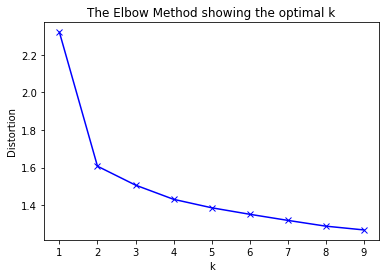

In [102]:
# k means determine k using elbow method
distortions = []
K = range(1,10)
X = cluster_examples
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow method suggest running k-means with 2 clusters.

### Silhouette score

The elbow method can be ambiguous, as an alternative the average silhouette method can be used.
<br>The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared 
<br>to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that 
<br>the object is well matched to its own cluster and poorly matched to neighboring clusters. 
<br>If most objects have a high value, then the clustering configuration is appropriate. 
<br>If many points have a low or negative value, then the clustering configuration may have too many or too few clusters. [2](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=Silhouette%20refers%20to%20a%20method,consistency%20within%20clusters%20of%20data.&text=The%20silhouette%20ranges%20from%20%E2%88%921,poorly%20matched%20to%20neighboring%20clusters.)

For n_clusters = 2 The average silhouette_score is : 0.42918515102058397
For n_clusters = 3 The average silhouette_score is : 0.3567074174995071
For n_clusters = 4 The average silhouette_score is : 0.24070918808741493
For n_clusters = 5 The average silhouette_score is : 0.22434060493609073
For n_clusters = 6 The average silhouette_score is : 0.17389624685103444
For n_clusters = 7 The average silhouette_score is : 0.177599211438364
For n_clusters = 8 The average silhouette_score is : 0.14609087690444306


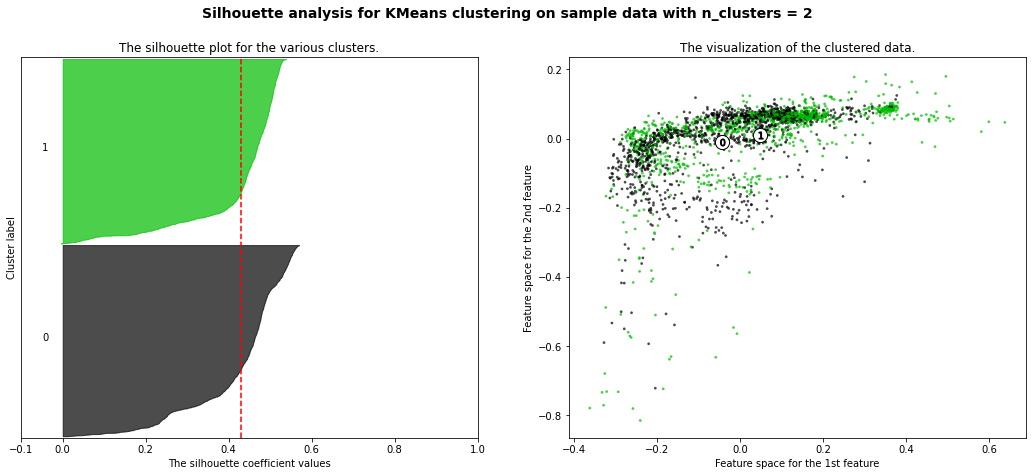

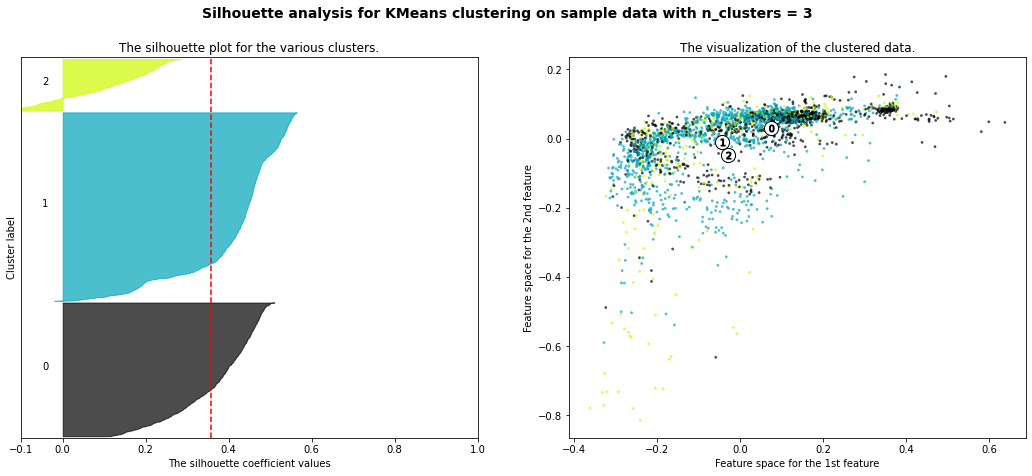

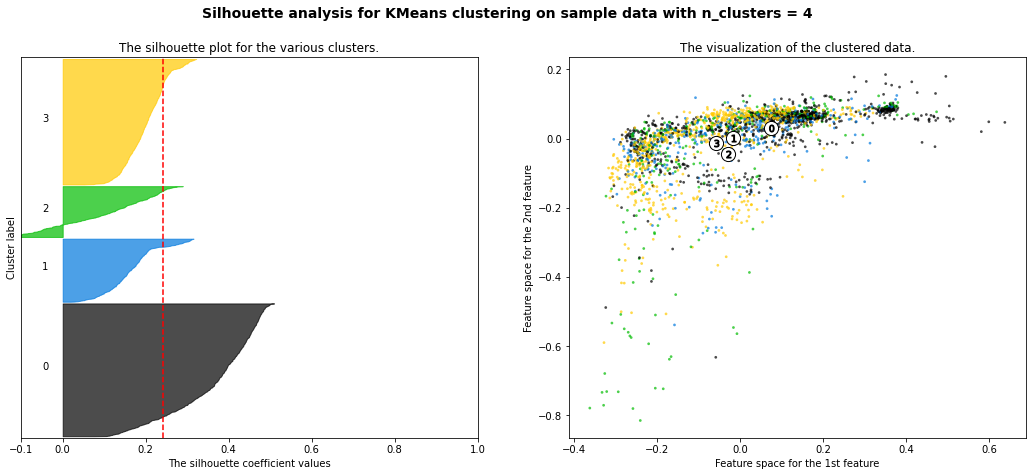

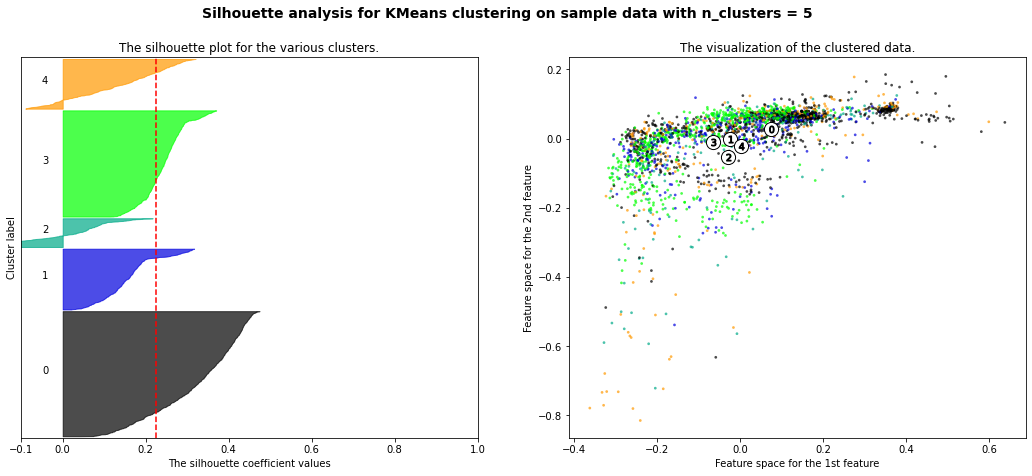

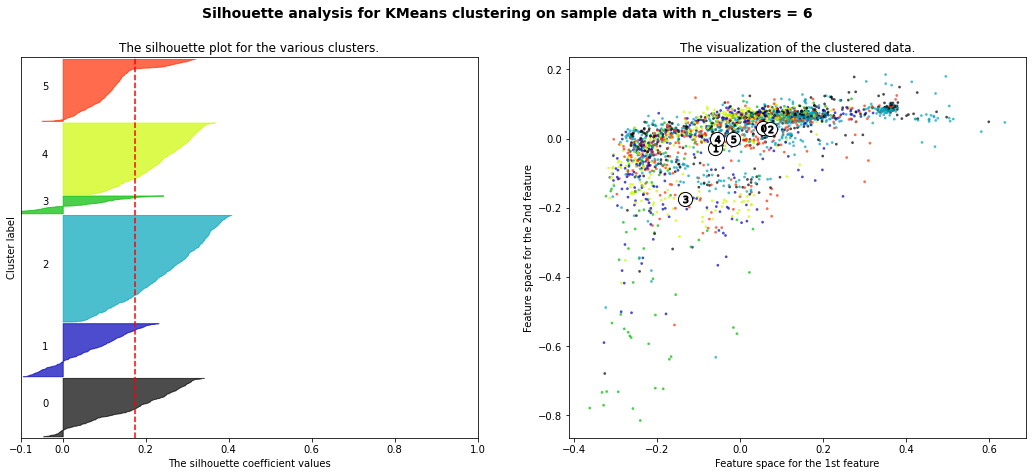

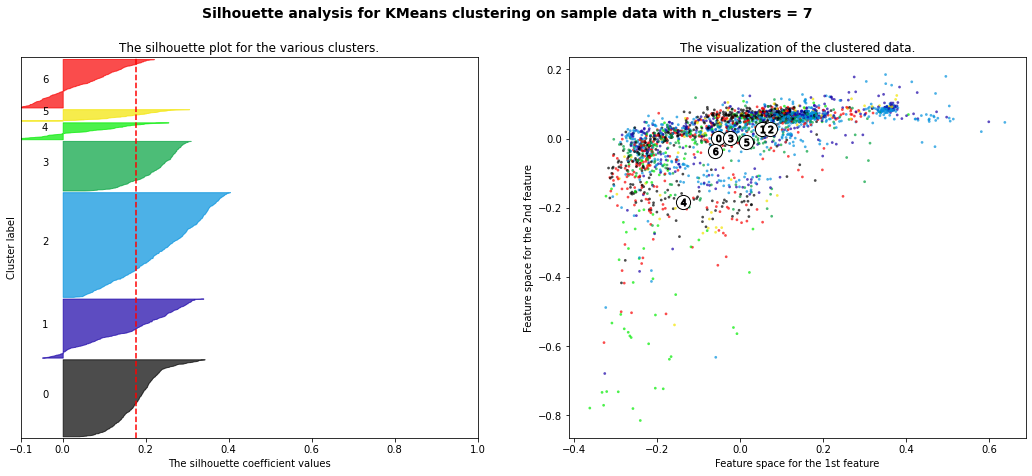

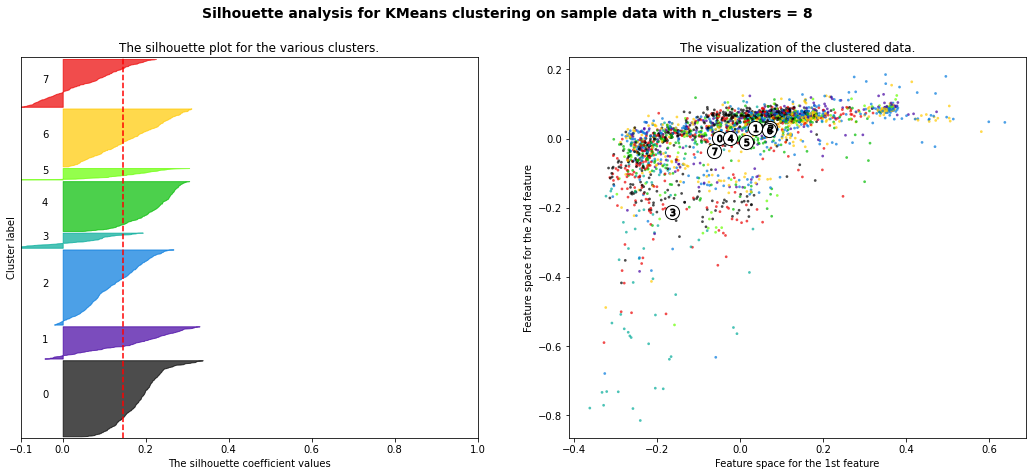

In [103]:
X = cluster_examples  
range_n_clusters = (2,3,4,5,6,7,8)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=555)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

For 2,3,5 and 6 clusters, the silhouette coefficient has higher values with best clustering separation for 2 clusters. 

## Clustering Experiments

We run now the experiment using k-means with two, three, five and six clusters and evaluate how the cloud providers are grouped in them.
<br>First we define the functions to execute the training and create an overview of the results.

In [104]:
experiments = [2,3,5,6]

In [105]:
data_clusters = df_data.copy()

In [106]:
data_clusters.head()

,usr0,usr1,usr2,usr3,usr4,usr5,usr6,usr7,usr8,usr9,...,1m83,1m84,1m85,1m86,1m87,1m88,1m89,1m90,1m91,classes
7986256a-5ada-4410-b6a6-ab7395e17f42,0.163779,0.058459,-0.008579,-0.031460,0.038991,-0.021702,0.014113,0.065829,0.103613,-0.110134,...,-0.056533,-0.048451,-0.042802,-0.0402,-0.05631,-0.034836,-0.02871,-0.042958,-0.039393,4
ca45e609-a7af-484c-8098-79f19eeb2f87,-0.020813,-0.023182,0.002118,0.018013,0.082778,0.103562,-0.059077,-0.144860,-0.250860,-0.029941,...,-0.056533,-0.048451,-0.042802,-0.0402,-0.05631,-0.034836,-0.02871,-0.042958,-0.039393,3
89d400ba-a6dd-4a36-bf36-99ddc1799e20,0.125834,0.088577,0.019594,0.014478,-0.213372,-0.078324,0.207520,0.275133,0.010057,-0.049286,...,-0.056533,-0.048451,-0.042802,-0.0402,-0.05631,-0.034836,-0.02871,-0.042958,-0.039393,3
28dacd65-3968-4bc3-845e-32d6d5b6728e,0.001227,0.066137,0.005997,-0.012902,0.009585,-0.082090,-0.106813,0.067087,0.113379,0.018885,...,-0.056533,-0.048451,-0.042802,-0.0402,-0.05631,-0.034836,-0.02871,-0.042958,-0.039393,4
472db6a8-3681-4cce-8b30-d93a9116e4d7,-0.246128,-0.062245,0.005584,-0.013287,-0.021689,-0.115687,-0.136297,0.087097,0.186279,-0.065609,...,0.085062,0.122737,0.121489,-0.0402,-0.05631,-0.034836,-0.02871,-0.042958,-0.039393,2


In [107]:
def k_training(c):
    clusterer = KMeans(n_clusters=c, random_state=555)
    cluster_labels = clusterer.fit_predict(X)
    k_labels = clusterer.labels_
    data_clusters['clusters_'+str(c)] = k_labels

In [108]:
#Create a dataframe with the original dataset and the resulting cluster label found during training of k-means.
classes_totals = data_clusters['classes'].value_counts()

We define a function to produce an overview of the resulting clustering including:
* List of cloud providers in each cluster.
* Percentage of the overall samples of the cloud provider included in the cluster `pclass`.
* Percentage of the cluster covered by the cloud provider `pcluster`.

In [109]:
def statistics(c):
    clusters_totals = data_clusters['clusters_'+str(c)].value_counts()
    stats = pd.DataFrame(data_clusters.groupby(by=['clusters_'+str(c),'classes'])['classes'].count())
    stats = stats.add_suffix('_count').reset_index()
    stats['p_class'] = (stats.apply(
        lambda x: 100*x['classes_count']/classes_totals[x['classes']], axis=1, result_type = 'expand')).round(2)
    stats['p_cluster'] = (stats.apply(
        lambda x: 100*x['classes_count']/clusters_totals[x['clusters_'+str(c)]], axis=1, result_type = 'expand')).round(2)
    stats['cloud_prov'] = stats.apply(
        lambda x: (classes_count[classes_count['id']==x['classes']]['cloud_prov']).values[0], axis=1, result_type = 'expand')
    return stats

We define a function to highlight in the table returned by `stats` the class with biggest coverage within a cluster.

In [110]:
def highlight_biggestclass(row):
#    if row.p_cluster > 50:
#        return ['background-color: cyan']*6
#    else:
#        return ['background-color: white']*6
     return ['background-color: orange' if (row.p_cluster > 50) else 'background-color: cyan' if (row.p_class > 50) else 'background-color: white']*6

# Experiments runs and results

Comparing with the amount of samples of each cloud provider in the original dataset

In [111]:
classes_count.sort_values(by='count', ascending=False)

,cloud_prov,id,count
0,rax,0,1017
3,ovh,3,704
4,inap-mtl01,4,320
2,vexxhost,2,149
1,limestone-regionone,1,103
6,packethost-us-west-1,6,51
5,fortnebula-regionone,5,33


## Experiment with 2 clusters

In [112]:
k_training(2)

In [113]:
stats = statistics(2)

In [114]:
stats.style.apply(highlight_biggestclass, axis=1)

,clusters_2,classes,classes_count,p_class,p_cluster,cloud_prov
0,0,0,1017,100.000000,87.150000,rax
1,0,1,103,100.000000,8.830000,limestone-regionone
2,0,2,47,31.540000,4.030000,vexxhost
3,1,2,102,68.460000,8.430000,vexxhost
4,1,3,704,100.000000,58.180000,ovh
5,1,4,320,100.000000,26.450000,inap-mtl01
6,1,5,33,100.000000,2.730000,fortnebula-regionone
7,1,6,51,100.000000,4.210000,packethost-us-west-1


Besides cloud operator `vexxhost`, which is distributed in the two clusters, the remaining cloud operators are separated in the two clusters. 
<br>However, this result is not significant for the aim of our experiments. 

## Experiment with 3 clusters

In [115]:
k_training(3)

In [116]:
stats = statistics(3)
stats.style.apply(highlight_biggestclass, axis=1)

,clusters_3,classes,classes_count,p_class,p_cluster,cloud_prov
0,0,0,810,79.650000,95.290000,rax
1,0,1,40,38.830000,4.710000,limestone-regionone
2,1,2,99,66.440000,8.260000,vexxhost
3,1,3,696,98.860000,58.100000,ovh
4,1,4,319,99.690000,26.630000,inap-mtl01
5,1,5,33,100.000000,2.750000,fortnebula-regionone
6,1,6,51,100.000000,4.260000,packethost-us-west-1
7,2,0,207,20.350000,62.920000,rax
8,2,1,63,61.170000,19.150000,limestone-regionone
9,2,2,50,33.560000,15.200000,vexxhost


Clustering of the cloud providers is divisive and not significant.

## Experiment with 4 clusters

In [117]:
k_training(4)
stats = statistics(4)
stats.style.apply(highlight_biggestclass, axis=1)

,clusters_4,classes,classes_count,p_class,p_cluster,cloud_prov
0,0,0,808,79.450000,95.280000,rax
1,0,1,40,38.830000,4.720000,limestone-regionone
2,1,4,319,99.690000,79.160000,inap-mtl01
3,1,5,33,100.000000,8.190000,fortnebula-regionone
4,1,6,51,100.000000,12.660000,packethost-us-west-1
5,2,0,209,20.550000,64.310000,rax
6,2,1,63,61.170000,19.380000,limestone-regionone
7,2,2,45,30.200000,13.850000,vexxhost
8,2,3,7,0.990000,2.150000,ovh
9,2,4,1,0.310000,0.310000,inap-mtl01


Three of the cloud operators have predominance in separate clusters. 
<br>Cloud operator `rax` is the one with highest supper in the dataset and dominates cluster 2 even though with only 20% of samples of its class.
<br>Cloud operator `inap` is grouped in a cluster with little noise and 99.69% of its samples.
<br>Cloud operator `ovh`  is grouped in a separate cluster with little noise and 99.01% of its samples.

## Experiment with 5 clusters

In [118]:
k_training(5)
stats = statistics(5)
stats.style.apply(highlight_biggestclass, axis=1)

,clusters_5,classes,classes_count,p_class,p_cluster,cloud_prov
0,0,0,762,74.930000,95.010000,rax
1,0,1,40,38.830000,4.990000,limestone-regionone
2,1,4,319,99.690000,81.790000,inap-mtl01
3,1,5,21,63.640000,5.380000,fortnebula-regionone
4,1,6,50,98.040000,12.820000,packethost-us-west-1
5,2,0,255,25.070000,79.940000,rax
6,2,1,63,61.170000,19.750000,limestone-regionone
7,2,2,1,0.670000,0.310000,vexxhost
8,3,2,89,59.730000,13.070000,vexxhost
9,3,3,592,84.090000,86.930000,ovh


<br>Cloud operator `inap` is grouped in a cluster with 99.69% of its samples and even less noise as in the experiment with 4 clusters.
<br>Cloud operators `rax` and `ovh` also have separate clusters with high class and cluster coverage. However they are also predominant in other two clusters as they have more samples as the remaining operators.  

## Experiment with 6 clusters

In [119]:
k_training(6)
stats = statistics(6)
stats.style.apply(highlight_biggestclass, axis=1)

,clusters_6,classes,classes_count,p_class,p_cluster,cloud_prov
0,0,0,360,35.400000,95.740000,rax
1,0,1,16,15.530000,4.260000,limestone-regionone
2,1,2,32,21.480000,9.360000,vexxhost
3,1,3,309,43.890000,90.350000,ovh
4,1,4,1,0.310000,0.290000,inap-mtl01
5,2,0,647,63.620000,94.310000,rax
6,2,1,39,37.860000,5.690000,limestone-regionone
7,3,0,10,0.980000,8.700000,rax
8,3,1,48,46.600000,41.740000,limestone-regionone
9,3,2,41,27.520000,35.650000,vexxhost


The resulting clustering is noise with exception of cloud operator `inap`

### Conclusion

Although the elbow method suggested 2 clusters and the silhouette score recommended 2 or 3 clusters as optimal number of clusters value for the clustering training, in the resulting experiments, the clustering with better differentiation among cloud providers was with 4 clusters. 
<br>We are not considering the experiment with 2 clusters the best result as we wanted to evaluate how many operators with high support a clustering algorith could group.  

For experiments with more than 3 clusters, the cloud operator `inap` was grouped in a separate cluster with very little noise and a 99.69% of its samples. This result indicates that the dstat data generated when running CI jobs on `inap` VM has a combination of values discernible enough for k-means to group them efficiently.

The top three cloud operators with higher support in the dataset (`rax`, `ovh` and `inap`) could be grouped in different clusters. 

Cloud operator `rax` has the highest support and had an unique cluster only for the experiment with 2 clusters, otherwise it was split into two clusters with the highest coverage of 79% of samples in a cluster for the experiment with 3 and 4 clusters. This might be due to the regions that were reduced to a single class.

Cloud operator `ovh` had the best coverage of samples in a single cluster for the experiment with 4 clusters (99%).

In general, the dstat data from the CI jobs has potential for further exploration using unsupervised learning. <br>Especially clustering of failed CI jobs could help engineers to better triage failures coming from the gate pipeline when considering the CI system in Openstack. Thsi approach could be used in other CI systems as well.